In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
sys.path.append('../src')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
%aimport psearch

In [3]:
from psearch import *

In [15]:
import dill

In [5]:
import math as mt
import numpy as np
import pandas as pd
import seaborn as sb
import pyfits as pf
import matplotlib.pyplot as plt
from IPython.display import clear_output

from glob import glob
from copy import copy
from os.path import join, basename, abspath

from numpy.core.records import array as rarr
from numpy.lib.recfunctions import stack_arrays, merge_arrays

In [6]:
sb.set_style('white')
sb.set_context('paper')
rc('figure', figsize=(14,5), dpi=100)
pd.set_option('precision', 3)

In [7]:
files = sorted(glob('../../../../../analysis/k2_05/injection_tests/data/reduced/EPIC_*.fits'))
epics = array(map(lambda fn:int(basename(fn).split('_')[1]), files))

In [8]:
results = {}

In [9]:
Y = [1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
     1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
     0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
     0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
     1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     1, 1, 0, 1, 1, 0, 1, 0, 0, 1]

time = linspace(0,10,1000)
k = 0.1
k2 = k**2
f = 0.5

flux_e = tm.evaluate(time, k, [], 1, 4, 4.6, 0.5*pi, e=0.01, w=0)
plot(time, 1 + f*(flux_e-1)/(1+f*k2))

In [20]:
fid = 50
ts = TransitSearch(files[fid])
ts()
results[fid] = ts.result

rf = '../../../../../analysis/k2_05/injection_tests/data/raw/ktwo{:9d}-c05_llc.fits'.format(ts.epic)
head = pf.getheader(rf,1)

print ts._rbls['bls_period'], head['inj_per'], head['inj_k'], head['inj_k']**2, '\n'

r = rarr(ts.result)
print 'lnlike 0: {:10.2f}'.format(float(r.lnlike_constant))
print 'lnlike 1: {:10.2f}'.format(float(r.lnlike_transit))
print 'lnlike 2: {:10.2f}'.format(float(r.lnlike_sine))
print 'lnlike 3: {:10.2f}'.format(float(r.lnlike_oe))

1.19003040131 1.18974782405 0.068187305373 0.00464950861403 

lnlike 0:   11436.27
lnlike 1:   11464.30
lnlike 2:   11436.27
lnlike 3:   11467.10


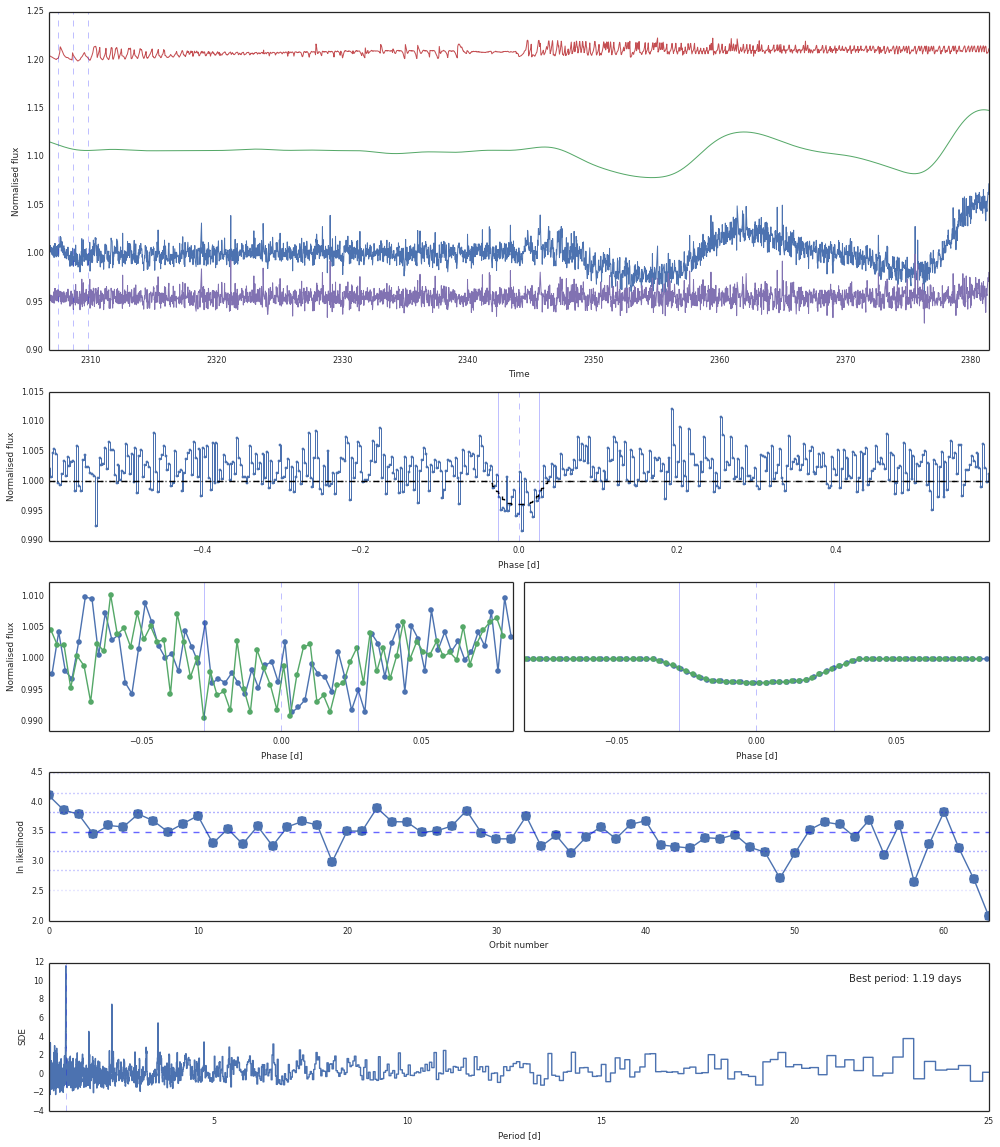

In [21]:
pmode = 'v'
#pmode = 'h'

if pmode == 'v':
    fig = figure(figsize=(14,16))
    gs = GridSpec(6,2)
    ax_lctime = subplot(gs[0:2,:])
    ax_lcfold = subplot(gs[2,:])
    ax_lnlike = subplot(gs[4,:])
    ax_lcoe   = subplot(gs[3,0]),subplot(gs[3,1])
    ax_sde    = subplot(gs[5,:])
elif pmode == 'h':
    fig = figure(figsize=(14,10))
    gs = GridSpec(3,4)
    ax_lctime = subplot(gs[0,:2])
    ax_lcfold = subplot(gs[1,:2])
    ax_lnlike = subplot(gs[0,2:])
    ax_sde    = subplot(gs[1,2:])
    ax_lcoe   = subplot(gs[2,:2]),subplot(gs[2,2:])
    
ts.plot_lc_time(ax_lctime)
ts.plot_lc(ax_lcfold)
ts.plot_even_odd_lc(ax_lcoe)
ts.plot_lnlike(ax_lnlike)
ts.plot_sde(ax_sde)
fig.tight_layout()

In [54]:
rr = pd.read_hdf('../../../../../analysis/k2_05/injection_tests/test_bls.h5', 'planet_search')

In [56]:
from collections import OrderedDict

In [ ]:
OrderedDict()

In [55]:
rr.sort('sde', ascending=False)

,epic,flux_median,flux_std,lnlike_constant,type,acor_raw,acor_corr,acor_trp,acor_trt,sde,...,lnlike_sine,sine_amplitude,lnlike_oe,oe_diff_k,oe_diff_a,oe_diff_b,po_lnlike_med,po_lnlike_std,po_lnlike_max,po_lnlike_min
485,212173873,33440.13,3.61e-04,19856.35,nan,11.30,0.11,12.38,31.47,16.69,...,19856.40,1.74e-06,20481.62,9.21e-04,4.57e-01,1.51e-03,6.38,0.38,1.51e+00,-2.70
240,211382023,759.38,4.06e-03,13821.75,nan,4.25,0.22,238.61,7.21,16.65,...,13821.75,3.97e-07,13977.65,1.61e-03,7.79e-01,1.98e-01,4.18,0.25,9.02e-01,-7.52
158,211836646,79322.92,1.39e-04,24296.32,nan,11.35,0.11,249.05,12.27,15.90,...,24296.34,4.71e-07,24399.47,1.18e-04,1.25e-01,8.02e-02,7.47,0.50,6.38e-01,-6.82
102,211844476,123048.91,1.91e-03,-894325.29,nan,1.72,1.44,248.45,2.05,15.82,...,-894325.40,2.17e-08,-191447.98,1.34e-03,1.17e-01,2.52e-03,-55.01,25.20,2.40e+00,-2.02
188,211839401,1297322.38,2.00e-03,-10650114.71,nan,1.38,2.57,147.07,1.42,15.78,...,-10650117.63,1.60e-08,-5647081.05,4.10e-03,3.29e-03,5.07e-02,-1496.92,1198.81,1.20e+00,-4.13
540,211434672,6649.15,8.52e-04,18049.71,nan,19.00,1.28,12.63,28.08,15.22,...,18052.05,3.14e-05,18083.28,3.26e-03,4.01e-01,4.65e-02,5.48,0.12,7.64e-01,-1.71
906,211480544,3788362.75,1.22e-03,-10777728.30,nan,1.70,0.92,144.17,1.68,15.21,...,-10776376.47,1.93e-05,-10499059.48,1.69e-02,3.27e+01,9.84e-02,-3886.98,1719.88,2.26e+00,-3.49
151,211701204,25910.68,2.33e-03,-154691.56,nan,2.38,1.49,28.76,2.92,15.02,...,-154672.11,3.48e-05,-4510.96,1.29e-04,3.30e-02,1.15e-03,-0.84,2.91,2.36e+00,-2.01
501,211620949,3427.18,1.84e-03,13491.06,nan,2.46,1.69,251.03,8.26,14.84,...,13491.93,3.32e-05,13582.09,9.83e-03,1.90e-01,3.39e-02,4.15,0.45,2.08e+00,-2.45
560,211722787,110384.66,3.20e-04,8376.98,nan,11.52,0.97,9.41,18.97,14.83,...,8376.98,1.35e-10,14349.02,1.38e-03,7.01e-03,2.12e-03,7.34,25.18,3.06e-02,-8.24


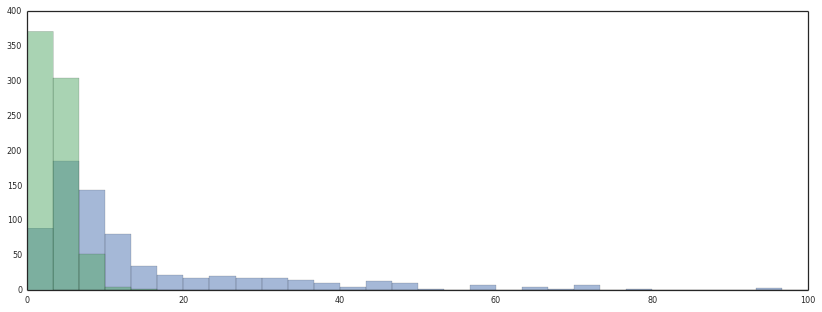

In [53]:
hist(rr.acor_raw, bins=30, range=(0,100), alpha=0.5);
hist(rr.acor_corr, bins=30, range=(0,100), alpha=0.5);

In [57]:
r = {}

In [59]:
r[1] = 'dsf'

In [60]:
len(r)

1

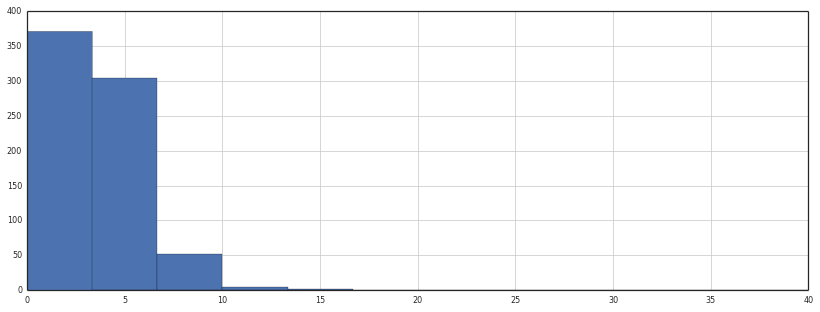

In [50]:
rr.acor_corr.hist(bins=30, range=(0,100))

In [38]:
import scipy.signal as sps

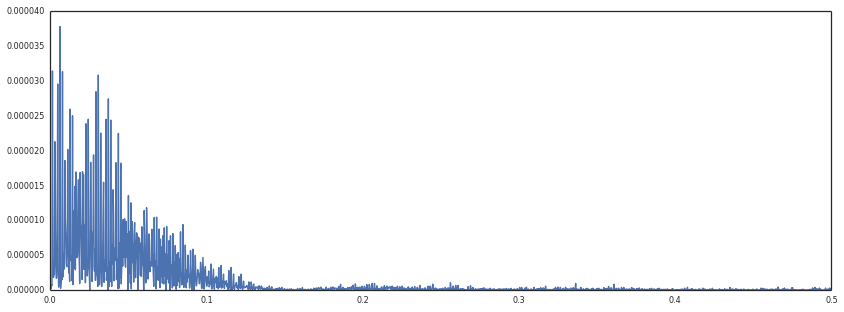

In [41]:
plot(*sps.periodogram(ts.flux))

In [64]:
import scipy.stats as st

In [ ]:
clip()

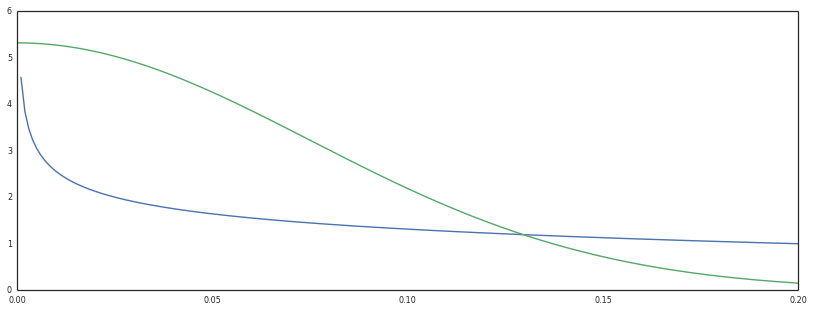

In [75]:
x = linspace(0, 0.2, 200)
plot(x, st.gamma.pdf(x, 0.75))
plot(x, st.norm.pdf(abs(x), 0, 0.075))

In [ ]:
for fid in range(120):
    ts = TransitSearch(files[fid])
    ts()
    results[fid] = ts.result
    if fid < 100:
        results[fid]['type'] = 'Planet' if Y[fid] == 1 else 'Trash'
    clear_output()
    display(fid)

In [ ]:
rfull = hstack(results.values())

In [76]:
from cPickle import load, dump

In [79]:
with open('lah.pkl','w') as f:
    dump(fig, f)

TypeError: expected string or Unicode object, NoneType found

In [ ]:
load()

In [ ]:
rfull['type'][array(Y, np.bool)] = 'Planet'
rfull['type'][~array(Y, np.bool)] = 'Trash'

In [ ]:
df_full = pd.DataFrame(rfull)

In [ ]:
def BIC(lnlike, npar, npt):
    return -2*lnlike + npar*log(npt)

In [ ]:
def create_input_df(df):
    tf = df.loc[:,'flux_std sde ntr trf_period trf_duration trf_radius_ratio '
                'trf_semi_major_axis trf_impact_parameter oe_diff_k po_lnlike_max po_lnlike_min'.split()]
    tf['log10_fm'] = log10(df.flux_median).replace(nan,0)
    tf['sin_amp'] = df.sine_amplitude
    tf['bic_c'] = BIC(df_full.lnlike_constant, 0, ts.flux.size)
    tf['bic_diff_tc'] = BIC(df_full.lnlike_transit,  5, ts.flux.size) - tf.bic_c
    tf['bic_diff_vc'] = BIC(df_full.lnlike_sine,     1, ts.flux.size) - tf.bic_c
    tf = tf.rename(columns=dict(bls_ntr = 'ntr', trf_period = 'period', trf_duration = 'T14', bls_sde='sde',
                          trf_radius_ratio='k', trf_semi_major_axis='a', trf_impact_parameter='b'))
    tf = tf.replace(nan, 0)
    return tf

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

In [ ]:
df_train = create_input_df(df_full[:100])
df_test  = create_input_df(df_full[100:])

In [ ]:
X = df_train.values
Y = df_full.type[:100]
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X, Y)

print clf.feature_importances_
print clf.predict_proba(df_test.values)
print clf.predict(df_test.values)

In [ ]:
scores = cross_val_score(clf, X, Y, cv=20)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
fsid = argsort(clf.feature_importances_)
hlines(range(clf.n_features_), 0, clf.feature_importances_[fsid])
ylim(-1,clf.n_features_)
yticks(range(clf.n_features_), df_train.columns[fsid]);

In [ ]:
pr_transit = clf.predict_proba(df_test.values)[:,1]
tids = argsort(pr_transit)[::-1]
pr_transit[tids]
print arange(100,120)[tids]

In [ ]:
plot(abs(fft.fft(ts.flux)))
ylim(0,1)
xlim(0,ts.flux.size//2)